# Model performance in production: all GB

This document contains the code used to compute performance scores of all the models used for the case of GB. It is the production version of [`explore_model_performance`](explore_model_performance).

In [111]:
import os, warnings
import pandas
import geopandas
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy

import tools_chip_prob_modelling as tools

data_p = '/home/jovyan/data/prod_model_outputs/'

## Compile preditions

For every pair of `(chipsize, arch)`, we have:

- 1 x unique geography
- 1 x set of true labels
- 5 x sets of predictions by different `(algo, variant)`

In each of these `(chipsize, arch)` blocks, we compile the data in a single table:

```
id | label | split | geometry | preds1 | preds2 | preds3 | preds4 | preds5
```

We then assemble all the tables in a single one, tagging each observation with the block they belong to.

In [2]:
ps = ! ls $data_p*_y_pred.pq
db = []
for chipsize in [8, 16, 32, 64]:
    for arch in ['bic', 'sic', 'mor']:
        db.append(tools.compile_chipsize_arch(chipsize, arch, ps))
db = pandas.concat(db).drop(columns=['HistGradientBoostingClassifier_baseline']) ### TEMP ###
db.iloc[:, 4:] = db.iloc[:, 4:].apply(lambda x: x.astype('category'))

db.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2552961 entries, 1 to 94959
Data columns (total 7 columns):
 #   Column              Dtype   
---  ------              -----   
 0   geometry            geometry
 1   label               category
 2   split               object  
 3   chipsize_arch       object  
 4   logite_baseline-wx  category
 5   logite_baseline     category
 6   maxprob             category
dtypes: category(4), geometry(1), object(2)
memory usage: 87.7+ MB


## Non-spatial scores

In [41]:
def nss(sub_db):
    metas = {}
    models = sub_db.drop(
        columns=['label', 'split', 'chipsize_arch']
    ).columns
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        for model in models:
            sub_train = sub_db.query('split == "ml_train"')
            sub_val = sub_db.query('split == "ml_val"')
            res = tools.build_perf(
                sub_train['label'],
                sub_train[model],
                sub_val['label'],
                sub_val[model],
                tools.class_names
            )
            metas[model] = deepcopy(res)
            del res
    return metas

In [4]:
from dask import dataframe as ddf
from dask.distributed import Client, LocalCluster

client = Client(LocalCluster(n_workers=4))

2022-08-18 21:31:24,142 - distributed.diskutils - INFO - Found stale lock file and directory '/home/jovyan/work/signature_ai/ai_experiments/dask-worker-space/worker-o0z5c_i4', purging
2022-08-18 21:31:24,142 - distributed.diskutils - INFO - Found stale lock file and directory '/home/jovyan/work/signature_ai/ai_experiments/dask-worker-space/worker-lhptm2gy', purging


In [ ]:
client.restart()

In [101]:
%%time
ddb = ddf.from_pandas(
    db[[c for c in db.columns if c != 'geometry']], npartitions=16
)

metas = ddb.groupby('chipsize_arch').apply(nss, meta=object).compute()

metass = {}
for csarch in metas.index:
    for i in metas[csarch]:
        metass[f'{csarch}_{i}'] = metas[csarch][i]
metrics = pandas.Series(metass)

/opt/conda/lib/python3.9/site-packages/dask/dataframe/core.py:6335: FutureWarning: Meta is not valid, `map_partitions` expects output to be a pandas object. Try passing a pandas object as meta or a dict or tuple representing the (name, dtype) of the columns. In the future the meta you passed will not work.
  warnings.warn(
ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


CPU times: user 30.2 s, sys: 4.5 s, total: 34.7 s
Wall time: 2min 50s


### Single scores

In [102]:
global_scores = []
for csam in metrics.index:
    global_scores.append(pandas.Series(
        {i.replace('perf_', '').replace('_val', ''): metrics[csam][i] for i in [
            'perf_kappa_val', 
            'perf_model_accuracy_val', 
            'perf_macro_f1_avg_val',
            'perf_macro_f1_w_val'
        ]},
        name=csam
    ))
global_scores = pandas.concat(
    global_scores, axis=1
).T
global_scores = global_scores.reset_index()
global_scores['chipsize'] = global_scores['index'].apply(lambda i: i.split('_')[0])
global_scores['arch'] = global_scores['index'].apply(lambda i: i.split('_')[1])
global_scores['model'] = global_scores['index'].apply(lambda i: '_'.join(i.split('_')[2:]))
global_scores = global_scores.set_index(
    ['arch', 'chipsize', 'model']
).drop(columns='index').sort_index()
global_scores

kappa  model_accuracy  macro_f1_avg  \
arch chipsize model                                                        
bic  16       logite_baseline     0.262573        0.359978      0.218918   
              logite_baseline-wx  0.338490        0.424620      0.283657   
              maxprob             0.187177        0.268460      0.220101   
     32       logite_baseline     0.312078        0.484423      0.424069   
              logite_baseline-wx  0.385497        0.520185      0.189641   
              maxprob             0.265221        0.418702      0.158186   
     64       logite_baseline     0.412455        0.603994      0.281847   
              logite_baseline-wx  0.507401        0.668651      0.166845   
              maxprob             0.319494        0.502788      0.139458   
     8        logite_baseline     0.247200        0.317034      0.267852   
              logite_baseline-wx  0.274374        0.341380      0.288410   
              maxprob             0.231938        0.298803      0.269592   
mor  16       logite_baseline     0.236548        0.308205      0.262601   
              logite_baseline-wx  0.265856        0.334788      0.285048   
              maxprob             0.212690        0.278210      0.238806   
     32       logite_baseline     0.298071        0.361052      0.348069   
              logite_baseline-wx  0.326147        0.386007      0.369164   
              maxprob             0.284674        0.348663      0.347660   
     64       logite_baseline     0.530732        0.575611      0.591522   
              logite_baseline-wx  0.542034        0.308205      0.599259   
              maxprob             0.534811        0.581403      0.616542   
     8        logite_baseline     0.235271        0.461804      0.250497   
              logite_baseline-wx  0.262831        0.334738      0.274581   
              maxprob             0.224009        0.293774      0.249718   
sic  16       logite_baseline     0.302232        0.363813      0.314556   
              logite_baseline-wx  0.409139        0.461804      0.405554   
              maxprob             0.292997        0.353988      0.321396   
     32       logite_baseline     0.301006        0.363654      0.317452   
              logite_baseline-wx  0.432935        0.484423      0.424069   
              maxprob             0.280813        0.343697      0.317935   
     64       logite_baseline     0.357339        0.467690      0.247860   
              logite_baseline-wx  0.298071        0.361052      0.348069   
              maxprob             0.347160        0.603994      0.281847   
     8        logite_baseline     0.275545        0.346236      0.266540   
              logite_baseline-wx  0.347406        0.411719      0.322358   
              maxprob             0.257021        0.323104      0.285466   

                                  macro_f1_w  
arch chipsize model                           
bic  16       logite_baseline       0.302027  
              logite_baseline-wx    0.369557  
              maxprob               0.269790  
     32       logite_baseline       0.464660  
              logite_baseline-wx    0.489613  
              maxprob               0.409116  
     64       logite_baseline       0.463225  
              logite_baseline-wx    0.656436  
              maxprob               0.533131  
     8        logite_baseline       0.279959  
              logite_baseline-wx    0.301027  
              maxprob               0.279775  
mor  16       logite_baseline       0.274972  
              logite_baseline-wx    0.298499  
              maxprob               0.247331  
     32       logite_baseline       0.340545  
              logite_baseline-wx    0.367329  
              maxprob               0.341805  
     64       logite_baseline       0.562239  
              logite_baseline-wx    0.572985  
              maxprob               0.575024  
     8        logite_baseline       0.424783  
              logite

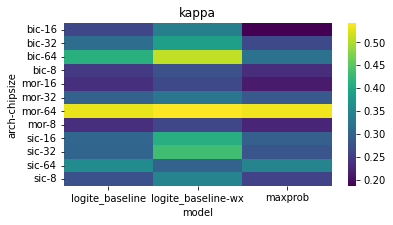

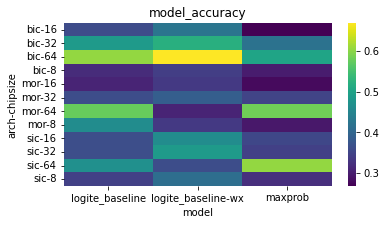

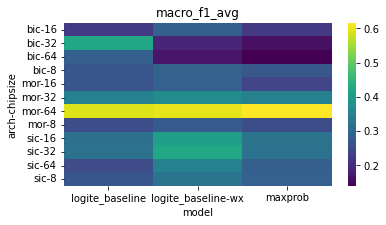

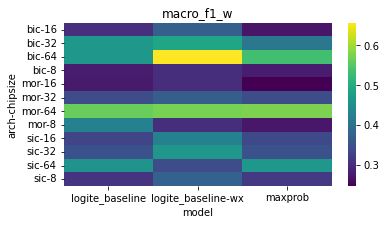

In [113]:
for score in global_scores:
    f, ax = plt.subplots(1, figsize=(6, 3))
    sns.heatmap(global_scores[score].unstack(), cmap='viridis', ax=ax)
    ax.set_title(score)

## Spatial scores